In [25]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

In [26]:


# Ensure we have a fresh connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Connection error: {e}")

def get_descriptive_stats(data, column_name):
    """Calculate comprehensive descriptive statistics"""
    stats_dict = {
        'count': len(data),
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75)
    }
    return stats_dict

def get_top_values(data, n=15):
    """Get top N occurring values with percentages"""
    value_counts = data.value_counts().head(n)
    percentages = (value_counts / len(data) * 100).round(2)
    return pd.DataFrame({
        'value': value_counts.index,
        'count': value_counts.values,
        'percentage': percentages.values
    })

def create_distribution_plots(data, title, bins=50):
    """Create histogram and box plot for a variable"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(data.dropna(), bins=bins, alpha=0.7, edgecolor='black')
    ax1.set_title(f'{title} - Distribution')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(data.dropna())
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📊 Helper functions defined successfully!")

✅ Database connection established
📊 Helper functions defined successfully!


# Step 1: Calculate CSF r-value for Equipment

We'll calculate the Contest Success Function (CSF) r-value using equipment values from both teams. The CSF formula is:

$$P(\text{win}) = \frac{x^r}{x^r + y^r}$$

Where:
- $x$ = higher equipment value
- $y$ = lower equipment value
- $r$ = parameter we estimate using Maximum Likelihood Estimation (MLE)

In [27]:
from scipy.optimize import minimize_scalar

# Query to get equipment values for both teams per round
query = """
SELECT 
    r.id,
	r.match_id,
    r.id_demo_exports,
	r.round_num,
    r.ct_winner,
    r.team1_winner,
    r.is_ct_t1,
    r.round_end_reason,
    -- CT team equipment
    SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
    -- T team equipment
    SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment,
    -- Higher and lower equipment
    CASE 
        WHEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) > 
             SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        THEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        ELSE SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
    END as higher_equipment,
    CASE 
        WHEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) <= 
             SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        THEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        ELSE SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
    END as lower_equipment,
    -- Did the higher equipment team win?
    CASE 
        WHEN (SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) > 
              SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) AND r.ct_winner)
        OR (SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) < 
            SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) AND NOT r.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won
FROM rounds_ed r
JOIN player_round_ed pr ON r.id = pr.round_id 
WHERE pr.eq_val_fte > 0  -- Valid equipment values
GROUP BY 1,2,3,4,5,6,7,8
HAVING SUM(CASE WHEN pr.team = 1 THEN pr.eq_val_fte ELSE 0 END) > 0
   AND SUM(CASE WHEN pr.team = 2 THEN pr.eq_val_fte ELSE 0 END) > 0
ORDER BY 1,2,3,4
"""

print("📊 Fetching equipment data from database...")
equipment_df = pd.read_sql_query(query, conn)
print(f"✅ Loaded {len(equipment_df):,} rounds")
print(f"   Matches: {equipment_df['match_id'].nunique():,}")
print(f"   Demos: {equipment_df['id_demo_exports'].nunique():,}")
print()

# Display sample data
print("Sample data:")
print(equipment_df.head(10))
print()
print("Data summary:")
print(equipment_df.describe())

📊 Fetching equipment data from database...


C:\Users\peter\AppData\Local\Temp\ipykernel_62960\3762691667.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  equipment_df = pd.read_sql_query(query, conn)


✅ Loaded 2,601,592 rounds
   Matches: 53,582
   Demos: 98,937

Sample data:
     id  match_id  id_demo_exports  round_num  ct_winner  team1_winner  \
0  5891   2366874              184          1       True         False   
1  5892   2366874              184          2       True         False   
2  5893   2366874              184          3       True         False   
3  5894   2366874              184          4      False          True   
4  5895   2366874              184          5      False          True   
5  5896   2366874              184          6      False          True   
6  5897   2366874              184          7      False          True   
7  5898   2366874              184          8      False          True   
8  5899   2366874              184          9       True         False   
9  5900   2366874              184         10      False          True   

   is_ct_t1  round_end_reason  ct_equipment  t_equipment  higher_equipment  \
0     False                 8  

In [28]:
# Define CSF log-likelihood function for MLE
def csf_log_likelihood(r, x, y, actual_wins):
    """
    Calculate negative log-likelihood for CSF model
    
    Parameters:
    - r: CSF parameter
    - x: higher equipment values
    - y: lower equipment values
    - actual_wins: 1 if higher equipment won, 0 otherwise
    """
    # Avoid division by zero and numerical issues
    r = max(r, 0.01)
    
    # Calculate predicted probabilities
    x_r = np.power(x, r)
    y_r = np.power(y, r)
    predicted_prob = x_r / (x_r + y_r)
    
    # Clip probabilities to avoid log(0)
    predicted_prob = np.clip(predicted_prob, 1e-10, 1 - 1e-10)
    
    # Calculate log-likelihood
    log_likelihood = np.sum(
        actual_wins * np.log(predicted_prob) + 
        (1 - actual_wins) * np.log(1 - predicted_prob)
    )
    
    # Return negative (for minimization)
    return -log_likelihood

# Estimate r-value using MLE
print("="*80)
print("🎯 CALCULATING CSF r-VALUE")
print("="*80)
print()

result = minimize_scalar(
    lambda r: csf_log_likelihood(r, 
                                equipment_df['higher_equipment'].values,
                                equipment_df['lower_equipment'].values,
                                equipment_df['higher_eq_won'].values),
    bounds=(0.01, 10),
    method='bounded'
)

csf_r_value = result.x

print(f"✅ Optimal r-value: {csf_r_value:.4f}")
print()
print(f"📊 Model Performance:")
print(f"   Higher equipment win rate: {equipment_df['higher_eq_won'].mean():.2%}")
print(f"   Log-likelihood: {-result.fun:.2f}")
print()

# Calculate predicted probabilities with optimal r
equipment_df['predicted_win_prob'] = (
    np.power(equipment_df['higher_equipment'], csf_r_value) / 
    (np.power(equipment_df['higher_equipment'], csf_r_value) + 
     np.power(equipment_df['lower_equipment'], csf_r_value))
)


print(f"💡 Interpretation:")
print(f"   r = {csf_r_value:.4f} means equipment advantage has ")
print()



🎯 CALCULATING CSF r-VALUE

✅ Optimal r-value: 1.0855

📊 Model Performance:
   Higher equipment win rate: 65.29%
   Log-likelihood: -1514257.48

💡 Interpretation:
   r = 1.0855 means equipment advantage has 

✅ Optimal r-value: 1.0855

📊 Model Performance:
   Higher equipment win rate: 65.29%
   Log-likelihood: -1514257.48

💡 Interpretation:
   r = 1.0855 means equipment advantage has 



# Step 2: Fetch Additional Round Data

Now we need to fetch data about:
1. **Round end reason** - How the round ended (elimination, bomb defused, time expired, etc.)
2. **Number of survivors** - How many players survived on the winning team
3. **Saved equipment** - Equipment value of survivors
4. **Money earned** - Money earned by teams

In [29]:
# Query for detailed round outcomes
query_detailed = """
WITH round_equipment AS (
    SELECT 
        r.id,
        r.match_id,
        r.id_demo_exports,
        r.round_num,
        r.ct_winner,
        r.team1_winner,
        r.is_ct_t1,
        r.round_end_reason,
        -- CT team equipment
        SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
        -- T team equipment
        SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment
    FROM rounds_ed r
    JOIN player_round_ed pr ON r.id = pr.round_id
    WHERE pr.eq_val_fte > 0
    GROUP BY 1,2,3,4,5,6,7,8
),
bomb_planted AS (
    SELECT 
        round_id,
        CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END as bomb_planted
    FROM bomb_events_round_ed
    WHERE bomb_event_type = 0
    GROUP BY round_id
),
round_survivors AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- Count total players per team (5 players each)
        -- CT survivors = 5 - (deaths of CT players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 = (pv.team = 1)) THEN k.victim_hltv_id 
        END) as ct_survivors,
        -- T survivors = 5 - (deaths of T players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 != (pv.team = 1)) THEN k.victim_hltv_id 
        END) as t_survivors
    FROM rounds_ed r
    LEFT JOIN kills_round_ed k ON r.id = k.round_id
    LEFT JOIN player_round_ed pv ON k.victim_hltv_id = pv.player_id AND k.round_id = pv.round_id
    GROUP BY 1,2
),
saved_equipment AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as ct_saved_equipment,
        -- T team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as t_saved_equipment
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id
    GROUP BY 1,2
),
player_money AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team player money (money_earned + money_earned_re) joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) 
            THEN COALESCE(pe.money_earned, 0)
            ELSE 0 END) as ct_player_money,
        -- T team player money (money_earned + money_earned_re) joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) 
            THEN COALESCE(pe.money_earned, 0)  
            ELSE 0 END) as t_player_money
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id
    GROUP BY 1,2
),
team_money AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- Team economy money_earned
        SUM(CASE WHEN te.team = 1 THEN COALESCE(te.money_earned, 0) ELSE 0 END) as team1_money_earned,
        SUM(CASE WHEN te.team = 2 THEN COALESCE(te.money_earned, 0) ELSE 0 END) as team2_money_earned
    FROM rounds_ed r
    LEFT JOIN team_economy_ed te ON r.id = te.round_id
    GROUP BY 1,2
)
SELECT 
    re.*,
    -- Add bomb planted status
    COALESCE(bp.bomb_planted, 0) as bomb_planted,
    -- Add survivor counts from round_survivors CTE
    rs.ct_survivors,
    rs.t_survivors,
    -- Higher and lower equipment
    CASE 
        WHEN re.ct_equipment > re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as higher_equipment,
    CASE 
        WHEN re.ct_equipment <= re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as lower_equipment,
    -- Did higher equipment team win?
    CASE 
        WHEN (re.ct_equipment > re.t_equipment AND re.ct_winner)
        OR (re.ct_equipment < re.t_equipment AND NOT re.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won,
    -- Winner's survivors (only from is_alive_re)
    CASE 
        WHEN re.ct_winner THEN rs.ct_survivors
        ELSE rs.t_survivors
    END as winner_survivors,
    -- Winner's saved equipment (from player_economy_ed.saved_eq_val)
    CASE 
        WHEN re.ct_winner THEN se.ct_saved_equipment
        ELSE se.t_saved_equipment
    END as winner_saved_equipment,
    -- CT and T saved equipment 
    se.ct_saved_equipment,
    se.t_saved_equipment,
    -- All money columns for analysis
    pm.ct_player_money,
    pm.t_player_money,
    tm.team1_money_earned,
    tm.team2_money_earned,
    -- Winner's money earned (sum of player money + team money)
    CASE 
        WHEN re.ct_winner THEN 
            pm.ct_player_money + CASE WHEN re.is_ct_t1 THEN tm.team1_money_earned ELSE tm.team2_money_earned END
        ELSE 
            pm.t_player_money + CASE WHEN re.is_ct_t1 THEN tm.team2_money_earned ELSE tm.team1_money_earned END
    END as winner_money_earned
FROM round_equipment re
LEFT JOIN bomb_planted bp ON re.id = bp.round_id
LEFT JOIN round_survivors rs ON re.id = rs.round_id
LEFT JOIN saved_equipment se ON re.id = se.round_id
LEFT JOIN player_money pm ON re.id = pm.round_id
LEFT JOIN team_money tm ON re.id = tm.round_id
WHERE re.ct_equipment > 0 AND re.t_equipment > 0
ORDER BY re.match_id, re.round_num
"""

print("📊 Fetching detailed round data...")
detailed_df = pd.read_sql_query(query_detailed, conn)
print(f"✅ Loaded {len(detailed_df):,} rounds with complete data")
print()

# Combine round end reasons 12 and 7
print("🔹 Pre-processing: Combining round end reasons 12 and 7")
detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({12: 7})
print(f"   Round end reasons 12 merged into 7")
print()

# Calculate CSF predictions for this dataset
detailed_df['predicted_win_prob'] = (
    np.power(detailed_df['higher_equipment'], csf_r_value) / 
    (np.power(detailed_df['higher_equipment'], csf_r_value) + 
     np.power(detailed_df['lower_equipment'], csf_r_value))
)

# Create CSF prediction binary (0 or 1)
detailed_df['csf_predicted_win'] = (detailed_df['predicted_win_prob'] > 0.5).astype(int)

print("Data summary:")
print(detailed_df[['higher_equipment', 'lower_equipment', 'winner_survivors', 
                   'winner_saved_equipment', 'winner_money_earned']].describe())




📊 Fetching detailed round data...


C:\Users\peter\AppData\Local\Temp\ipykernel_62960\2036107739.py:148: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  detailed_df = pd.read_sql_query(query_detailed, conn)


✅ Loaded 2,601,592 rounds with complete data

🔹 Pre-processing: Combining round end reasons 12 and 7
   Round end reasons 12 merged into 7

Data summary:
Data summary:
       higher_equipment  lower_equipment  winner_survivors  \
count      2.601592e+06     2.601592e+06      2.601592e+06   
mean       2.546655e+04     1.541231e+04      2.941811e+00   
std        7.220807e+03     9.523122e+03      1.260978e+00   
min        1.000000e+03     8.000000e+02      0.000000e+00   
25%        2.375000e+04     5.150000e+03      2.000000e+00   
50%        2.745000e+04     1.780000e+04      3.000000e+00   
75%        3.010000e+04     2.445000e+04      4.000000e+00   
max        4.055000e+04     3.650000e+04      5.000000e+00   

       winner_saved_equipment  winner_money_earned  
count            2.476855e+06         2.476855e+06  
mean             1.308559e+04         2.048453e+04  
std              7.690333e+03         4.378215e+03  
min             -5.000000e+00        -5.395000e+04  
25%     

# Case 1: Distributions Based on Win/Loss and CT/T

Calculate distributions of survivors, saved equipment, and money earned based on:
- Win vs Loss
- CT vs T side
- Round end reason percentages for each combination

In [30]:
print("="*80)
print("📊 CASE 1: DISTRIBUTIONS BY WIN/LOSS AND CT/T (SEPARATED)")
print("="*80)
print()

# Create separate dataframes for each combination
ct_win = detailed_df[detailed_df['ct_winner'] == True]
ct_loss = detailed_df[detailed_df['ct_winner'] == False]

print(f"Total rounds: {len(detailed_df):,}")
print(f"CT Wins: {len(ct_win):,} ({len(ct_win)/len(detailed_df)*100:.1f}%)")
print(f"CT Losses (T Wins): {len(ct_loss):,} ({len(ct_loss)/len(detailed_df)*100:.1f}%)")
print()

# Function to analyze CT side
def analyze_ct_side(data, outcome_name):
    print(f"\n{'='*70}")
    print(f"📌 CT SIDE - {outcome_name}")
    print('='*70)
    
    # CT Survivors
    print(f"\n🔹 CT SURVIVORS:")
    ct_survivors = data['ct_survivors']
    print(f"  Mean: {ct_survivors.mean():.2f}")
    print(f"  Median: {ct_survivors.median():.0f}")
    print(f"  Distribution:")
    surv_dist = ct_survivors.value_counts().sort_index()
    for surv, count in surv_dist.items():
        pct = count / len(data) * 100
        print(f"    {surv} survivors: {count:,} ({pct:.1f}%)")
    
    # CT Saved Equipment
    print(f"\n🔹 CT SAVED EQUIPMENT:")
    ct_saved_eq = data['ct_saved_equipment']
    print(f"  Mean: ${ct_saved_eq.mean():.0f}")
    print(f"  Median: ${ct_saved_eq.median():.0f}")
    print(f"  25th percentile: ${ct_saved_eq.quantile(0.25):.0f}")
    print(f"  75th percentile: ${ct_saved_eq.quantile(0.75):.0f}")
    
    # CT Money Earned
    print(f"\n🔹 CT MONEY EARNED:")
    ct_money = data.apply(lambda row: 
        row['ct_player_money'] + (row['team1_money_earned'] if row['is_ct_t1'] else row['team2_money_earned']), 
        axis=1)
    print(f"  Mean: ${ct_money.mean():.0f}")
    print(f"  Median: ${ct_money.median():.0f}")
    print(f"  25th percentile: ${ct_money.quantile(0.25):.0f}")
    print(f"  75th percentile: ${ct_money.quantile(0.75):.0f}")
    
    # Round End Reason
    print(f"\n🔹 ROUND END REASON (%):")
    round_end_dist = data['round_end_reason'].value_counts()
    round_end_pct = (round_end_dist / len(data) * 100).round(1)
    for reason, pct in round_end_pct.items():
        # Calculate bomb plant percentage for this round end reason
        reason_data = data[data['round_end_reason'] == reason]
        bomb_plant_pct = (reason_data['bomb_planted'].sum() / len(reason_data) * 100)
        print(f"  {reason}: {pct}% (bomb planted: {bomb_plant_pct:.1f}%)")
    
    return {
        'side': 'CT',
        'outcome': outcome_name,
        'survivors_mean': ct_survivors.mean(),
        'saved_eq_mean': ct_saved_eq.mean(),
        'money_mean': ct_money.mean(),
        'round_end_dist': round_end_pct
    }

# Function to analyze T side
def analyze_t_side(data, outcome_name):
    print(f"\n{'='*70}")
    print(f"📌 T SIDE - {outcome_name}")
    print('='*70)
    
    # T Survivors
    print(f"\n🔹 T SURVIVORS:")
    t_survivors = data['t_survivors']
    print(f"  Mean: {t_survivors.mean():.2f}")
    print(f"  Median: {t_survivors.median():.0f}")
    print(f"  Distribution:")
    surv_dist = t_survivors.value_counts().sort_index()
    for surv, count in surv_dist.items():
        pct = count / len(data) * 100
        print(f"    {surv} survivors: {count:,} ({pct:.1f}%)")
    
    # T Saved Equipment
    print(f"\n🔹 T SAVED EQUIPMENT:")
    t_saved_eq = data['t_saved_equipment']
    print(f"  Mean: ${t_saved_eq.mean():.0f}")
    print(f"  Median: ${t_saved_eq.median():.0f}")
    print(f"  25th percentile: ${t_saved_eq.quantile(0.25):.0f}")
    print(f"  75th percentile: ${t_saved_eq.quantile(0.75):.0f}")
    
    # T Money Earned
    print(f"\n🔹 T MONEY EARNED:")
    t_money = data.apply(lambda row: 
        row['t_player_money'] + (row['team2_money_earned'] if row['is_ct_t1'] else row['team1_money_earned']), 
        axis=1)
    print(f"  Mean: ${t_money.mean():.0f}")
    print(f"  Median: ${t_money.median():.0f}")
    print(f"  25th percentile: ${t_money.quantile(0.25):.0f}")
    print(f"  75th percentile: ${t_money.quantile(0.75):.0f}")
    
    # Round End Reason
    print(f"\n🔹 ROUND END REASON (%):")
    round_end_dist = data['round_end_reason'].value_counts()
    round_end_pct = (round_end_dist / len(data) * 100).round(1)
    for reason, pct in round_end_pct.items():
        # Calculate bomb plant percentage for this round end reason
        reason_data = data[data['round_end_reason'] == reason]
        bomb_plant_pct = (reason_data['bomb_planted'].sum() / len(reason_data) * 100)
        print(f"  {reason}: {pct}% (bomb planted: {bomb_plant_pct:.1f}%)")
    
    return {
        'side': 'T',
        'outcome': outcome_name,
        'survivors_mean': t_survivors.mean(),
        'saved_eq_mean': t_saved_eq.mean(),
        'money_mean': t_money.mean(),
        'round_end_dist': round_end_pct
    }

# Analyze all combinations - CT and T separately for wins and losses
results = []

print("\n" + "="*80)
print("WHEN CT WINS:")
print("="*80)
results.append(analyze_ct_side(ct_win, "WIN"))
results.append(analyze_t_side(ct_win, "LOSS"))

print("\n" + "="*80)
print("WHEN CT LOSES (T WINS):")
print("="*80)
results.append(analyze_ct_side(ct_loss, "LOSS"))
results.append(analyze_t_side(ct_loss, "WIN"))

print("\n" + "="*80)
print("✅ Case 1 Complete!")
print("="*80)

# Export Case 1 results
print("\n📁 Exporting Case 1 results...")
case1_results_df = pd.DataFrame(results)
case1_results_df.to_json('case1_side_outcome_summary.json', orient='records', indent=2)
print("✅ Exported: case1_side_outcome_summary.json")

# Export detailed survivor distributions
ct_win_ct_surv = ct_win['ct_survivors'].value_counts().sort_index()
ct_win_t_surv = ct_win['t_survivors'].value_counts().sort_index()
ct_loss_ct_surv = ct_loss['ct_survivors'].value_counts().sort_index()
ct_loss_t_surv = ct_loss['t_survivors'].value_counts().sort_index()

survivor_dist_df = pd.DataFrame({
    'survivors': range(0, 6),
    'ct_win_ct_count': [ct_win_ct_surv.get(i, 0) for i in range(0, 6)],
    'ct_win_t_count': [ct_win_t_surv.get(i, 0) for i in range(0, 6)],
    'ct_loss_ct_count': [ct_loss_ct_surv.get(i, 0) for i in range(0, 6)],
    'ct_loss_t_count': [ct_loss_t_surv.get(i, 0) for i in range(0, 6)]
})

survivor_dist_df.to_json('case1_survivor_distributions.json', orient='records', indent=2)
print("✅ Exported: case1_survivor_distributions.json")

📊 CASE 1: DISTRIBUTIONS BY WIN/LOSS AND CT/T (SEPARATED)

Total rounds: 2,601,592
CT Wins: 1,339,476 (51.5%)
CT Losses (T Wins): 1,262,116 (48.5%)


WHEN CT WINS:

📌 CT SIDE - WIN

🔹 CT SURVIVORS:
  Mean: 3.04
  Median: 3
  Distribution:
    0 survivors: 8,025 (0.6%)
    1 survivors: 155,463 (11.6%)
    2 survivors: 298,508 (22.3%)
    3 survivors: 366,571 (27.4%)
    4 survivors: 330,055 (24.6%)
    5 survivors: 180,854 (13.5%)

🔹 CT SAVED EQUIPMENT:
  Mean: $14066
  Median: $14600
  25th percentile: $8500
  75th percentile: $19950

🔹 CT MONEY EARNED:
Total rounds: 2,601,592
CT Wins: 1,339,476 (51.5%)
CT Losses (T Wins): 1,262,116 (48.5%)


WHEN CT WINS:

📌 CT SIDE - WIN

🔹 CT SURVIVORS:
  Mean: 3.04
  Median: 3
  Distribution:
    0 survivors: 8,025 (0.6%)
    1 survivors: 155,463 (11.6%)
    2 survivors: 298,508 (22.3%)
    3 survivors: 366,571 (27.4%)
    4 survivors: 330,055 (24.6%)
    5 survivors: 180,854 (13.5%)

🔹 CT SAVED EQUIPMENT:
  Mean: $14066
  Median: $14600
  25th perc

# Case 2: Distributions Based on CSF Prediction

Calculate how survivors, equipment saved, and money earned relate to CSF predictions.
This shows how equipment advantage (predicted by CSF) affects round outcomes.

📊 CASE 2: DISTRIBUTIONS BASED ON CSF PREDICTION (CONTINUOUS)

📌 CSF Probability Range:
  Min: 50.0%
  Max: 98.3%
  Mean: 65.7%
  Median: 58.2%

📌 Sample CSF Probabilities (every 1% from 50% to 100%):
CSF %      Rounds     Actual Win%     Avg W Surv   Avg L Surv   Avg Saved$      Avg Money$     
---------------------------------------------------------------------------------------------------------
50%        129794     41.6%           2.73         0.28         $7870           $20915         
51%        216498     50.7%           2.74         0.32         $9482           $20796         
52%        179778     51.7%           2.74         0.36         $11557          $20633         
53%        167380     52.8%           2.74         0.37         $12478          $20483         
54%        167935     53.8%           2.74         0.35         $12312          $20413         
55%        154524     54.9%           2.74         0.33         $12474          $20360         
56%        126007     

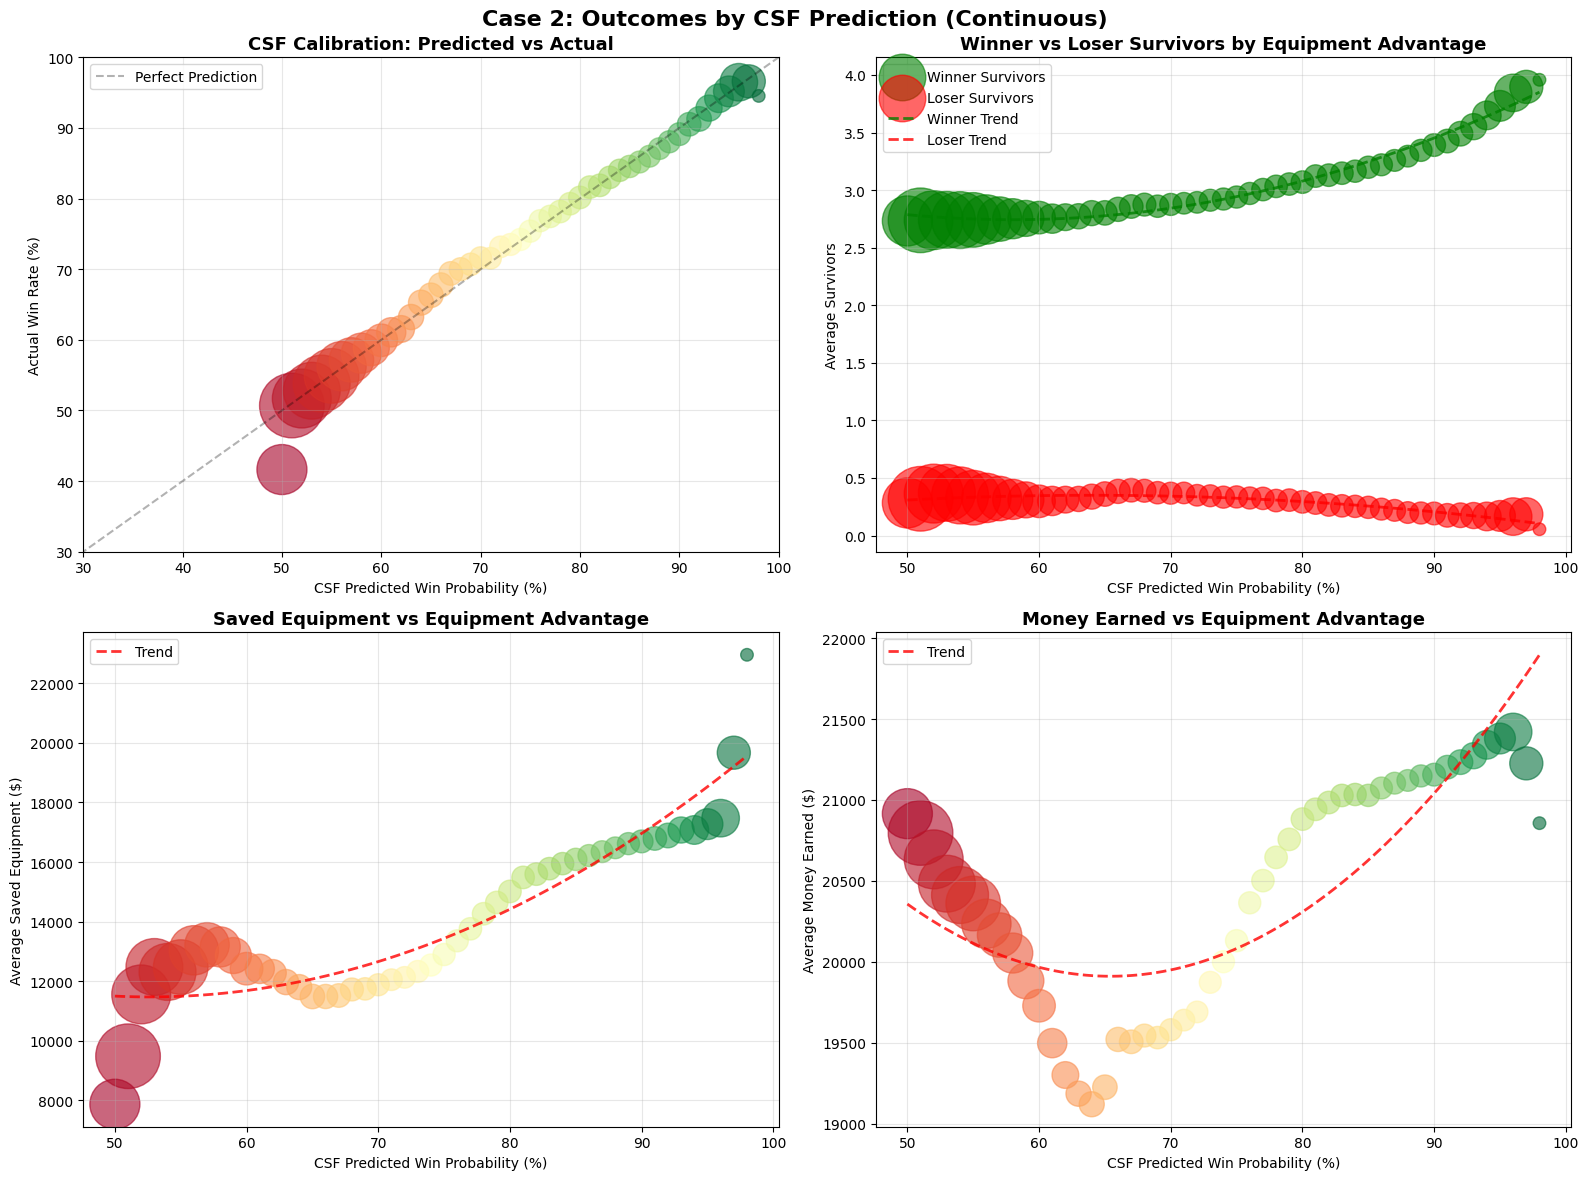


✅ Case 2 Complete!

📁 Exporting Case 2 results...
✅ Exported: case2_csf_continuous_analysis.json
✅ Exported: case2_detailed_rounds_with_csf.json
✅ Exported: case2_detailed_rounds_with_csf.json


In [31]:
print("="*80)
print("📊 CASE 2: DISTRIBUTIONS BASED ON CSF PREDICTION (CONTINUOUS)")
print("="*80)
print()

# Use continuous CSF probabilities - create percentile groups for analysis
detailed_df['csf_prob_pct'] = (detailed_df['predicted_win_prob'] * 100).round(0).astype(int)

print("📌 CSF Probability Range:")
print(f"  Min: {detailed_df['predicted_win_prob'].min():.1%}")
print(f"  Max: {detailed_df['predicted_win_prob'].max():.1%}")
print(f"  Mean: {detailed_df['predicted_win_prob'].mean():.1%}")
print(f"  Median: {detailed_df['predicted_win_prob'].median():.1%}")
print()

# Calculate loser survivors
detailed_df['loser_survivors'] = detailed_df.apply(
    lambda row: row['t_survivors'] if row['ct_winner'] else row['ct_survivors'],
    axis=1
)

# Group by CSF probability percentages for detailed view
csf_grouped = detailed_df.groupby('csf_prob_pct').agg({
    'id': 'count',
    'higher_eq_won': 'mean',
    'winner_survivors': 'mean',
    'loser_survivors': 'mean',
    'winner_saved_equipment': 'mean',
    'winner_money_earned': 'mean'
}).rename(columns={'id': 'count'})

print("📌 Sample CSF Probabilities (every 1% from 50% to 100%):")
print(f"{'CSF %':<10} {'Rounds':<10} {'Actual Win%':<15} {'Avg W Surv':<12} {'Avg L Surv':<12} {'Avg Saved$':<15} {'Avg Money$':<15}")
print("-" * 105)
for pct in range(50, 101, 1):
    if pct in csf_grouped.index:
        row = csf_grouped.loc[pct]
        print(f"{pct}%{'':<7} {row['count']:<10.0f} {row['higher_eq_won']:<15.1%} "
              f"{row['winner_survivors']:<12.2f} {row['loser_survivors']:<12.2f} "
              f"${row['winner_saved_equipment']:<14.0f} ${row['winner_money_earned']:<14.0f}")

# Create continuous data for plotting
csf_results_df = csf_grouped.reset_index()
csf_results_df.columns = ['csf_prob_pct', 'count', 'actual_win_rate', 
                          'survivors_mean', 'loser_survivors_mean', 
                          'saved_eq_mean', 'money_mean']


# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Case 2: Outcomes by CSF Prediction (Continuous)', fontsize=16, fontweight='bold')

# Plot 1: Actual Win Rate vs CSF Probability
ax1 = axes[0, 0]
# Plot every data point for full resolution
valid_probs = csf_results_df[csf_results_df['count'] >= 10]  # Filter out very rare probabilities
ax1.scatter(valid_probs['csf_prob_pct'], valid_probs['actual_win_rate'] * 100, 
           alpha=0.6, s=valid_probs['count']/100, c=valid_probs['csf_prob_pct'], cmap='RdYlGn')
ax1.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Perfect Prediction')
ax1.set_xlabel('CSF Predicted Win Probability (%)')
ax1.set_ylabel('Actual Win Rate (%)')
ax1.set_title('CSF Calibration: Predicted vs Actual', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(30, 100)
ax1.set_ylim(30, 100)

# Plot 2: Survivors vs CSF Probability
ax2 = axes[0, 1]
# Plot winner survivors
ax2.scatter(valid_probs['csf_prob_pct'], valid_probs['survivors_mean'], 
           alpha=0.6, s=valid_probs['count']/100, c='green', label='Winner Survivors')
# Plot loser survivors
ax2.scatter(valid_probs['csf_prob_pct'], valid_probs['loser_survivors_mean'], 
           alpha=0.6, s=valid_probs['count']/100, c='red', label='Loser Survivors')
# Add trend lines
z_winner = np.polyfit(valid_probs['csf_prob_pct'], valid_probs['survivors_mean'], 2)
p_winner = np.poly1d(z_winner)
z_loser = np.polyfit(valid_probs['csf_prob_pct'], valid_probs['loser_survivors_mean'], 2)
p_loser = np.poly1d(z_loser)
x_trend = np.linspace(valid_probs['csf_prob_pct'].min(), valid_probs['csf_prob_pct'].max(), 100)
ax2.plot(x_trend, p_winner(x_trend), "g--", alpha=0.8, linewidth=2, label='Winner Trend')
ax2.plot(x_trend, p_loser(x_trend), "r--", alpha=0.8, linewidth=2, label='Loser Trend')
ax2.set_xlabel('CSF Predicted Win Probability (%)')
ax2.set_ylabel('Average Survivors')
ax2.set_title('Winner vs Loser Survivors by Equipment Advantage', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Saved Equipment vs CSF Probability
ax3 = axes[1, 0]
ax3.scatter(valid_probs['csf_prob_pct'], valid_probs['saved_eq_mean'], 
           alpha=0.6, s=valid_probs['count']/100, c=valid_probs['csf_prob_pct'], cmap='RdYlGn')
# Add trend line
z = np.polyfit(valid_probs['csf_prob_pct'], valid_probs['saved_eq_mean'], 2)
p = np.poly1d(z)
ax3.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Trend')
ax3.set_xlabel('CSF Predicted Win Probability (%)')
ax3.set_ylabel('Average Saved Equipment ($)')
ax3.set_title('Saved Equipment vs Equipment Advantage', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Money Earned vs CSF Probability
ax4 = axes[1, 1]
ax4.scatter(valid_probs['csf_prob_pct'], valid_probs['money_mean'], 
           alpha=0.6, s=valid_probs['count']/100, c=valid_probs['csf_prob_pct'], cmap='RdYlGn')
# Add trend line
z = np.polyfit(valid_probs['csf_prob_pct'], valid_probs['money_mean'], 2)
p = np.poly1d(z)
ax4.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Trend')
ax4.set_xlabel('CSF Predicted Win Probability (%)')
ax4.set_ylabel('Average Money Earned ($)')
ax4.set_title('Money Earned vs Equipment Advantage', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ Case 2 Complete!")
print("="*80)

# Export Case 2 results
print("\n📁 Exporting Case 2 results...")
csf_results_df.to_json('case2_csf_continuous_analysis.json', orient='records', indent=2)
print("✅ Exported: case2_csf_continuous_analysis.json")

# Export full detailed data with CSF predictions
detailed_export = detailed_df[[
    'id', 'match_id', 'round_num', 'ct_winner', 'is_ct_t1', 'round_end_reason',
    'ct_equipment', 't_equipment', 'higher_equipment', 'lower_equipment',
    'ct_survivors', 't_survivors', 'winner_survivors', 'loser_survivors',
    'ct_saved_equipment', 't_saved_equipment', 'winner_saved_equipment',
    'ct_player_money', 't_player_money', 'winner_money_earned',
    'predicted_win_prob', 'csf_predicted_win', 'higher_eq_won', 'csf_prob_pct'
]].copy()
detailed_export.to_json('case2_detailed_rounds_with_csf.json', orient='records', indent=2)
print("✅ Exported: case2_detailed_rounds_with_csf.json")

In [32]:
print("="*80)
print("📊 CASE 2 ENHANCEMENTS: SURVIVOR DISTRIBUTIONS")
print("="*80)
print()

# Enhancement 3: Full Survivor Probability Distributions (not just means)
print("🔹 FULL SURVIVOR DISTRIBUTIONS BY CSF PROBABILITY (INTEGER %)")
print("-" * 70)

survivor_distributions = []

# Use integer CSF percentages (every 1% from 50% to 100%)
print(f"\nProcessing survivor distributions for CSF probabilities 50% to 100%...")
print(f"Showing sample distributions (every 5%):\n")

for csf_pct in range(50, 101):
    csf_data = detailed_df[detailed_df['csf_prob_pct'] == csf_pct]
    
    if len(csf_data) == 0:
        continue
    
    # Only print every 5% for readability, but store all
    if csf_pct % 5 == 0:
        print(f"\n{csf_pct}% CSF Probability ({len(csf_data):,} rounds):")
    
    # Winner survivors distribution
    winner_surv_dist = csf_data['winner_survivors'].value_counts().sort_index()
    if csf_pct % 5 == 0:
        print(f"  Winner Survivors Distribution:")
    for surv in range(6):
        count = winner_surv_dist.get(surv, 0)
        prob = count / len(csf_data) if len(csf_data) > 0 else 0
        if csf_pct % 5 == 0:
            print(f"    {surv} survivors: {prob:.1%} ({count:,} rounds)")
        survivor_distributions.append({
            'csf_prob_pct': csf_pct,
            'team': 'winner',
            'survivors': surv,
            'count': int(count),
            'probability': prob
        })
    
    # Loser survivors distribution
    loser_surv_dist = csf_data['loser_survivors'].value_counts().sort_index()
    if csf_pct % 5 == 0:
        print(f"  Loser Survivors Distribution:")
    for surv in range(6):
        count = loser_surv_dist.get(surv, 0)
        prob = count / len(csf_data) if len(csf_data) > 0 else 0
        if csf_pct % 5 == 0:
            print(f"    {surv} survivors: {prob:.1%} ({count:,} rounds)")
        survivor_distributions.append({
            'csf_prob_pct': csf_pct,
            'team': 'loser',
            'survivors': surv,
            'count': int(count),
            'probability': prob
        })

survivor_dist_df = pd.DataFrame(survivor_distributions)

print("\n" + "="*80)
print("✅ Case 2 Enhancements Complete!")
print("="*80)

# Export survivor distributions
print("\n📁 Exporting Case 2 enhancement results...")
survivor_dist_df.to_json('case2_survivor_distributions_by_advantage.json', orient='records', indent=2)
print("✅ Exported: case2_survivor_distributions_by_advantage.json")

📊 CASE 2 ENHANCEMENTS: SURVIVOR DISTRIBUTIONS

🔹 FULL SURVIVOR DISTRIBUTIONS BY CSF PROBABILITY (INTEGER %)
----------------------------------------------------------------------

Processing survivor distributions for CSF probabilities 50% to 100%...
Showing sample distributions (every 5%):


50% CSF Probability (129,794 rounds):
  Winner Survivors Distribution:
    0 survivors: 2.0% (2,563 rounds)
    1 survivors: 15.4% (19,995 rounds)
    2 survivors: 26.0% (33,686 rounds)
    3 survivors: 28.4% (36,879 rounds)
    4 survivors: 20.6% (26,738 rounds)
    5 survivors: 7.7% (9,933 rounds)
  Loser Survivors Distribution:
    0 survivors: 82.0% (106,394 rounds)
    1 survivors: 10.6% (13,782 rounds)
    2 survivors: 5.0% (6,435 rounds)
    3 survivors: 2.1% (2,705 rounds)
    4 survivors: 0.3% (439 rounds)
    5 survivors: 0.0% (39 rounds)

50% CSF Probability (129,794 rounds):
  Winner Survivors Distribution:
    0 survivors: 2.0% (2,563 rounds)
    1 survivors: 15.4% (19,995 rounds)
   

# Case 3: Hierarchical Analysis - CSF → Round End Reason → Outcomes

This creates a decision tree structure:
1. Calculate round end reason distribution based on CSF (differentiating CT/T)
2. For each round end reason, calculate CT and T survivors
3. For each round end reason, calculate saved equipment
4. For each round end reason, calculate money earned

In [33]:
print("="*80)
print("📊 CASE 3: HIERARCHICAL ANALYSIS - CSF → ROUND END → OUTCOMES (CONTINUOUS)")
print("="*80)
print()

# Import scipy for distribution testing
from scipy import stats as scipy_stats

# Helper function to analyze distribution properties
def analyze_distribution(data, name="Value"):
    """Analyze distribution properties for ABM parameterization"""
    if len(data) == 0 or data.isna().all():
        return None
    
    # Remove NaN and infinite values
    clean_data = data.replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(clean_data) < 3:
        return None
    
    # Basic statistics
    stats_dict = {
        'count': int(len(clean_data)),
        'mean': float(clean_data.mean()),
        'std': float(clean_data.std()),
        'median': float(clean_data.median()),
        'min': float(clean_data.min()),
        'max': float(clean_data.max()),
        'q25': float(clean_data.quantile(0.25)),
        'q75': float(clean_data.quantile(0.75)),
        'q10': float(clean_data.quantile(0.10)),
        'q90': float(clean_data.quantile(0.90)),
        'skewness': float(scipy_stats.skew(clean_data)),
        'kurtosis': float(scipy_stats.kurtosis(clean_data))
    }
    
    # Test for normality (Shapiro-Wilk for small samples, Anderson-Darling for large)
    if len(clean_data) < 5000:
        stat, p_value = scipy_stats.shapiro(clean_data[:5000])  # Shapiro-Wilk has max 5000
        stats_dict['normality_test'] = 'shapiro'
        stats_dict['normality_stat'] = float(stat)
        stats_dict['normality_pvalue'] = float(p_value)
        stats_dict['is_normal'] = bool(p_value > 0.05)
    else:
        result = scipy_stats.anderson(clean_data, dist='norm')
        stats_dict['normality_test'] = 'anderson'
        stats_dict['normality_stat'] = float(result.statistic)
        stats_dict['is_normal'] = bool(result.statistic < result.critical_values[2])  # 5% significance
    
    # Suggest distribution type
    if stats_dict['is_normal']:
        stats_dict['suggested_distribution'] = 'normal'
    elif stats_dict['min'] >= 0 and stats_dict['skewness'] > 1:
        stats_dict['suggested_distribution'] = 'lognormal or gamma'
    elif stats_dict['min'] == 0 and stats_dict['max'] <= 100:
        stats_dict['suggested_distribution'] = 'beta or truncated_normal'
    else:
        stats_dict['suggested_distribution'] = 'empirical (use percentiles)'
    
    return stats_dict

# LEVEL 1: Round End Reason Distribution by CSF Percentage (Continuous)
print("🔹 LEVEL 1: Round End Reason by CSF Probability (Continuous Integer %)")
print("-" * 70)

level1_results = []

# Process CSF percentages from 50% to 100%
print("\nProcessing CSF probabilities 50% to 100% (showing every 10%)...\n")

for csf_pct in range(50, 101):
    csf_data = detailed_df[detailed_df['csf_prob_pct'] == csf_pct]
    
    if len(csf_data) == 0:
        continue
    
    # Separate by CT winner vs T winner
    for ct_wins in [True, False]:
        winner = "CT" if ct_wins else "T"
        outcome_data = csf_data[csf_data['ct_winner'] == ct_wins]
        
        if len(outcome_data) == 0:
            continue
        
        # Only print every 10% for readability
        if csf_pct % 10 == 0:
            print(f"\nCSF {csf_pct}% → {winner} Wins ({len(outcome_data):,} rounds):")
        
        round_end_dist = outcome_data['round_end_reason'].value_counts()
        
        for reason, count in round_end_dist.items():
            pct = count / len(outcome_data) * 100
            if csf_pct % 10 == 0:
                print(f"  Reason {reason}: {pct:.1f}%")
            
            level1_results.append({
                'csf_prob_pct': csf_pct,
                'winner': winner,
                'round_end_reason': reason,
                'count': int(count),
                'percentage': float(pct),
                'total_rounds_in_group': len(outcome_data)
            })

level1_df = pd.DataFrame(level1_results)
print(f"\n✅ Level 1: {len(level1_df)} combinations processed")
print()

# LEVEL 2: Survivor Distributions by Round End Reason (Full Probability Distributions)
print("🔹 LEVEL 2: Survivor Distributions by Round End Reason (Full Stats)")
print("-" * 70)

level2_results = []
level2_distributions = []
top_round_ends = detailed_df['round_end_reason'].value_counts().head(10).index  # Top 10 reasons

for reason in top_round_ends:
    reason_data = detailed_df[detailed_df['round_end_reason'] == reason]
    
    print(f"\nReason {reason} ({len(reason_data):,} rounds):")
    
    # CT Survivors - Full distribution
    ct_surv_dist = reason_data['ct_survivors'].value_counts().sort_index()
    ct_dist_stats = analyze_distribution(reason_data['ct_survivors'], "CT Survivors")
    
    print(f"  CT Survivors Distribution:")
    print(f"    Mean: {ct_dist_stats['mean']:.2f}, Std: {ct_dist_stats['std']:.2f}")
    print(f"    Median: {ct_dist_stats['median']:.0f}, [Q10-Q90]: [{ct_dist_stats['q10']:.0f}, {ct_dist_stats['q90']:.0f}]")
    print(f"    Normality: {'Yes' if ct_dist_stats['is_normal'] else 'No'} (suggested: {ct_dist_stats['suggested_distribution']})")
    
    # Store overall stats
    level2_results.append({
        'round_end_reason': reason,
        'side': 'CT',
        **ct_dist_stats
    })
    
    # Store individual probabilities
    for surv in range(6):
        count = ct_surv_dist.get(surv, 0)
        prob = count / len(reason_data)
        print(f"    {surv} survivors: {prob:.1%}")
        level2_distributions.append({
            'round_end_reason': reason,
            'side': 'CT',
            'survivors': surv,
            'count': int(count),
            'probability': float(prob)
        })
    
    # T Survivors - Full distribution
    t_surv_dist = reason_data['t_survivors'].value_counts().sort_index()
    t_dist_stats = analyze_distribution(reason_data['t_survivors'], "T Survivors")
    
    print(f"  T Survivors Distribution:")
    print(f"    Mean: {t_dist_stats['mean']:.2f}, Std: {t_dist_stats['std']:.2f}")
    print(f"    Median: {t_dist_stats['median']:.0f}, [Q10-Q90]: [{t_dist_stats['q10']:.0f}, {t_dist_stats['q90']:.0f}]")
    print(f"    Normality: {'Yes' if t_dist_stats['is_normal'] else 'No'} (suggested: {t_dist_stats['suggested_distribution']})")
    
    # Store overall stats
    level2_results.append({
        'round_end_reason': reason,
        'side': 'T',
        **t_dist_stats
    })
    
    # Store individual probabilities
    for surv in range(6):
        count = t_surv_dist.get(surv, 0)
        prob = count / len(reason_data)
        print(f"    {surv} survivors: {prob:.1%}")
        level2_distributions.append({
            'round_end_reason': reason,
            'side': 'T',
            'survivors': surv,
            'count': int(count),
            'probability': float(prob)
        })

level2_df = pd.DataFrame(level2_results)
level2_dist_df = pd.DataFrame(level2_distributions)
print(f"\n✅ Level 2: {len(level2_df)} survivor distributions processed")
print()

# LEVEL 3A: 3D Lookup - Saved Equipment by Round End, Starting Equipment, and Survivors
print("🔹 LEVEL 3A: 3D Lookup Table - Saved Equipment % (Round End × Start Eq × Survivors)")
print("-" * 70)

level3a_results = []

# Define starting equipment value ranges (continuous $100 increments)
eq_increment = 100

for reason in top_round_ends:
    reason_data = detailed_df[detailed_df['round_end_reason'] == reason]
    
    print(f"\nReason {reason} ({len(reason_data):,} rounds):")
    
    # CT Saved Equipment - 3D: Starting Equipment × Survivors
    print(f"  CT - 3D Lookup Table (Starting Eq × Survivors):")
    
    # Round starting equipment to nearest $100 for grouping
    ct_eq_rounded = (reason_data['ct_equipment'] / eq_increment).round() * eq_increment
    
    # Get unique starting equipment values (sorted)
    unique_ct_eq = sorted(ct_eq_rounded.unique())
    
    # Sample output for display (show $10k, $15k, $20k with all survivor counts)
    display_eq_values = [10000, 15000, 20000]
    
    for start_eq_val in unique_ct_eq:
        eq_group = reason_data[ct_eq_rounded == start_eq_val]
        
        # Print header for display values
        if start_eq_val in display_eq_values and len(eq_group) >= 3:
            print(f"    Starting Eq ${start_eq_val:.0f}:")
        
        # Loop through each survivor count (0-5)
        for surv_count in range(6):
            surv_group = eq_group[eq_group['ct_survivors'] == surv_count]
            
            if len(surv_group) >= 3:  # Need minimum samples for distribution
                ct_saved_pct = (surv_group['ct_saved_equipment'] / surv_group['ct_equipment']).replace([np.inf, -np.inf], np.nan) * 100
                ct_dist = analyze_distribution(ct_saved_pct, f"CT ${start_eq_val:.0f} {surv_count}surv")
                
                if ct_dist:
                    # Only print for display equipment values
                    if start_eq_val in display_eq_values:
                        print(f"      {surv_count} survivors ({ct_dist['count']:3d} rounds): "
                              f"Mean={ct_dist['mean']:5.1f}%, Median={ct_dist['median']:5.1f}%, "
                              f"Std={ct_dist['std']:5.1f}%, Normal={'Y' if ct_dist['is_normal'] else 'N'}")
                    
                    # Store ALL combinations for export
                    level3a_results.append({
                        'round_end_reason': reason,
                        'side': 'CT',
                        'starting_equipment': float(start_eq_val),
                        'survivors': surv_count,
                        'metric': 'saved_pct_of_original',
                        **ct_dist,
                        'absolute_saved_mean': float(surv_group['ct_saved_equipment'].mean()),
                        'absolute_saved_std': float(surv_group['ct_saved_equipment'].std())
                    })
    
    # T Saved Equipment - 3D: Starting Equipment × Survivors
    print(f"  T - 3D Lookup Table (Starting Eq × Survivors):")
    
    # Round starting equipment to nearest $100 for grouping
    t_eq_rounded = (reason_data['t_equipment'] / eq_increment).round() * eq_increment
    
    # Get unique starting equipment values (sorted)
    unique_t_eq = sorted(t_eq_rounded.unique())
    
    for start_eq_val in unique_t_eq:
        eq_group = reason_data[t_eq_rounded == start_eq_val]
        
        # Print header for display values
        if start_eq_val in display_eq_values and len(eq_group) >= 3:
            print(f"    Starting Eq ${start_eq_val:.0f}:")
        
        # Loop through each survivor count (0-5)
        for surv_count in range(6):
            surv_group = eq_group[eq_group['t_survivors'] == surv_count]
            
            if len(surv_group) >= 3:  # Need minimum samples for distribution
                t_saved_pct = (surv_group['t_saved_equipment'] / surv_group['t_equipment']).replace([np.inf, -np.inf], np.nan) * 100
                t_dist = analyze_distribution(t_saved_pct, f"T ${start_eq_val:.0f} {surv_count}surv")
                
                if t_dist:
                    # Only print for display equipment values
                    if start_eq_val in display_eq_values:
                        print(f"      {surv_count} survivors ({t_dist['count']:3d} rounds): "
                              f"Mean={t_dist['mean']:5.1f}%, Median={t_dist['median']:5.1f}%, "
                              f"Std={t_dist['std']:5.1f}%, Normal={'Y' if t_dist['is_normal'] else 'N'}")
                    
                    # Store ALL combinations for export
                    level3a_results.append({
                        'round_end_reason': reason,
                        'side': 'T',
                        'starting_equipment': float(start_eq_val),
                        'survivors': surv_count,
                        'metric': 'saved_pct_of_original',
                        **t_dist,
                        'absolute_saved_mean': float(surv_group['t_saved_equipment'].mean()),
                        'absolute_saved_std': float(surv_group['t_saved_equipment'].std())
                    })

level3a_df = pd.DataFrame(level3a_results)
print(f"\n✅ Level 3A: {len(level3a_df)} 3D combinations processed")
print()

# LEVEL 3B: Money Earned Distributions
print("🔹 LEVEL 3B: Money Earned Distributions by Round End Reason")
print("-" * 70)

level3b_results = []

for reason in top_round_ends:
    reason_data = detailed_df[detailed_df['round_end_reason'] == reason]
    
    print(f"\nReason {reason} ({len(reason_data):,} rounds):")
    
    # CT Money (player + team)
    ct_money = reason_data.apply(lambda row: 
        row['ct_player_money'] + (row['team1_money_earned'] if row['is_ct_t1'] else row['team2_money_earned']), 
        axis=1)
    ct_dist = analyze_distribution(ct_money, "CT Money")
    
    if ct_dist:
        print(f"  CT Money Earned:")
        print(f"    Mean: ${ct_dist['mean']:.0f}, Std: ${ct_dist['std']:.0f}")
        print(f"    Median: ${ct_dist['median']:.0f}, [Q10-Q90]: [${ct_dist['q10']:.0f}, ${ct_dist['q90']:.0f}]")
        print(f"    Normal: {'Yes' if ct_dist['is_normal'] else 'No'}, Suggested: {ct_dist['suggested_distribution']}")
        
        level3b_results.append({
            'round_end_reason': reason,
            'side': 'CT',
            'metric': 'money_earned',
            **ct_dist
        })
    
    # T Money (player + team)
    t_money = reason_data.apply(lambda row: 
        row['t_player_money'] + (row['team2_money_earned'] if row['is_ct_t1'] else row['team1_money_earned']), 
        axis=1)
    t_dist = analyze_distribution(t_money, "T Money")
    
    if t_dist:
        print(f"  T Money Earned:")
        print(f"    Mean: ${t_dist['mean']:.0f}, Std: ${t_dist['std']:.0f}")
        print(f"    Median: ${t_dist['median']:.0f}, [Q10-Q90]: [${t_dist['q10']:.0f}, ${t_dist['q90']:.0f}]")
        print(f"    Normal: {'Yes' if t_dist['is_normal'] else 'No'}, Suggested: {t_dist['suggested_distribution']}")
        
        level3b_results.append({
            'round_end_reason': reason,
            'side': 'T',
            'metric': 'money_earned',
            **t_dist
        })

level3b_df = pd.DataFrame(level3b_results)
print(f"\n✅ Level 3B: {len(level3b_results)} money distributions processed")

print("\n" + "="*80)
print("✅ Case 3 Complete!")
print("="*80)

# Export Case 3 results
print("\n📁 Exporting Case 3 results (continuous distributions with full statistics)...")
level1_df.to_json('case3_level1_round_end_by_csf_continuous.json', orient='records', indent=2)
print("✅ Exported: case3_level1_round_end_by_csf_continuous.json")

level2_df.to_json('case3_level2_survivor_distribution_stats.json', orient='records', indent=2)
print("✅ Exported: case3_level2_survivor_distribution_stats.json")

level2_dist_df.to_json('case3_level2_survivor_probabilities.json', orient='records', indent=2)
print("✅ Exported: case3_level2_survivor_probabilities.json")

level3a_df.to_json('case3_level3a_saved_equipment_3d_lookup.json', orient='records', indent=2)
print("✅ Exported: case3_level3a_saved_equipment_3d_lookup.json")
print("   📊 3D Lookup Table: Round End Reason × Starting Equipment × Survivors")
print(f"   📊 Total combinations: {len(level3a_df)}")

level3b_df.to_json('case3_level3b_money_distributions.json', orient='records', indent=2)
print("✅ Exported: case3_level3b_money_distributions.json")

print("\n📊 Case 3 exports complete!")
print("📊 All distributions include:")
print("  ✅ Mean, Std, Median, Min, Max")
print("  ✅ Quartiles (Q10, Q25, Q75, Q90)")
print("  ✅ Skewness & Kurtosis")
print("  ✅ Normality tests (Shapiro-Wilk/Anderson-Darling)")
print("  ✅ Suggested distribution types for ABM")
print("\n📊 Level 3 provides 3D lookup table:")
print("  🔹 Dimension 1: Round End Reason (1, 7, 8, 9, 10...)")
print("  🔹 Dimension 2: Starting Equipment ($100 increments)")
print("  🔹 Dimension 3: Number of Survivors (0-5)")
print("  🔹 Output: Full distribution of saved equipment %")



📊 CASE 3: HIERARCHICAL ANALYSIS - CSF → ROUND END → OUTCOMES (CONTINUOUS)

🔹 LEVEL 1: Round End Reason by CSF Probability (Continuous Integer %)
----------------------------------------------------------------------

Processing CSF probabilities 50% to 100% (showing every 10%)...


CSF 50% → CT Wins (65,671 rounds):
  Reason 8: 62.0%
  Reason 7: 38.0%

CSF 50% → T Wins (64,123 rounds):
  Reason 9: 71.6%
  Reason 1: 28.3%
  Reason 8: 0.0%

CSF 50% → CT Wins (65,671 rounds):
  Reason 8: 62.0%
  Reason 7: 38.0%

CSF 50% → T Wins (64,123 rounds):
  Reason 9: 71.6%
  Reason 1: 28.3%
  Reason 8: 0.0%

CSF 60% → CT Wins (30,010 rounds):
  Reason 8: 67.1%
  Reason 7: 32.9%

CSF 60% → T Wins (25,013 rounds):
  Reason 9: 68.6%
  Reason 1: 31.3%
  Reason 8: 0.0%

CSF 60% → CT Wins (30,010 rounds):
  Reason 8: 67.1%
  Reason 7: 32.9%

CSF 60% → T Wins (25,013 rounds):
  Reason 9: 68.6%
  Reason 1: 31.3%
  Reason 8: 0.0%

CSF 70% → CT Wins (11,539 rounds):
  Reason 8: 70.2%
  Reason 7: 29.8%

CSF 7

c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $10000:
      1 survivors (124 rounds): Mean= 41.8%, Median= 43.5%, Std= 12.2%, Normal=N
      2 survivors (263 rounds): Mean= 78.6%, Median= 78.6%, Std= 20.9%, Normal=N
      3 survivors (314 rounds): Mean=108.8%, Median=109.2%, Std= 27.2%, Normal=N
      4 survivors (183 rounds): Mean=140.4%, Median=136.8%, Std= 33.0%, Normal=N
      5 survivors ( 49 rounds): Mean=165.4%, Median=160.3%, Std= 27.7%, Normal=Y
    Starting Eq $15000:
      1 survivors ( 49 rounds): Mean= 34.2%, Median= 32.7%, Std=  8.8%, Normal=N
      2 survivors (150 rounds): Mean= 57.9%, Median= 59.5%, Std= 17.9%, Normal=N
      3 survivors (178 rounds): Mean= 81.3%, Median= 84.0%, Std= 21.0%, Normal=N
      4 survivors (147 rounds): Mean=109.0%, Median=112.4%, Std= 26.7%, Normal=N
      5 survivors ( 66 rounds): Mean=128.6%, Median=128.1%, Std= 28.2%, Normal=N
    Starting Eq $15000:
      1 survivors ( 49 rounds): Mean= 34.2%, Median= 32.7%, Std=  8.8%, Normal=N
      2 survivors (150 rounds): Mean=

c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

  T - 3D Lookup Table (Starting Eq × Survivors):


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $10000:
      0 survivors (2169 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.6%, Normal=N
      1 survivors ( 30 rounds): Mean=  4.2%, Median=  0.0%, Std= 12.7%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $15000:
      0 survivors (1204 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.4%, Normal=N
      1 survivors ( 12 rounds): Mean=  3.3%, Median=  0.0%, Std= 11.5%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $20000:
      0 survivors (2661 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.8%, Normal=N
      1 survivors ( 31 rounds): Mean=  1.5%, Median=  0.0%, Std=  5.9%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet


Reason 9 (863,653 rounds):
  CT - 3D Lookup Table (Starting Eq × Survivors):


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $10000:
      0 survivors (2603 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.9%, Normal=N
      1 survivors ( 27 rounds): Mean=  6.4%, Median=  0.0%, Std= 13.1%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $15000:
      0 survivors (788 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=N
      1 survivors (  4 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $20000:
      0 survivors (1669 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=N
      1 survivors ( 15 rounds): Mean=  5.2%, Median=  0.0%, Std= 10.9%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

  T - 3D Lookup Table (Starting Eq × Survivors):


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $10000:
      0 survivors (  5 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors (206 rounds): Mean= 44.8%, Median= 46.1%, Std= 17.4%, Normal=N
      2 survivors (213 rounds): Mean= 87.8%, Median= 89.1%, Std= 23.2%, Normal=N
      3 survivors (152 rounds): Mean=121.1%, Median=122.5%, Std= 31.0%, Normal=N
      4 survivors ( 65 rounds): Mean=147.2%, Median=154.2%, Std= 48.6%, Normal=N
      5 survivors ( 19 rounds): Mean=191.3%, Median=180.5%, Std= 25.3%, Normal=Y


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $15000:
      0 survivors (  4 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors (191 rounds): Mean= 29.4%, Median= 28.9%, Std=  9.4%, Normal=N
      2 survivors (259 rounds): Mean= 57.2%, Median= 57.1%, Std= 11.5%, Normal=N
      3 survivors (222 rounds): Mean= 81.4%, Median= 81.1%, Std= 19.3%, Normal=N
      4 survivors (168 rounds): Mean= 96.8%, Median= 98.8%, Std= 26.5%, Normal=N
      5 survivors ( 82 rounds): Mean=117.5%, Median=119.5%, Std= 30.2%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $20000:
      0 survivors (  9 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors (704 rounds): Mean= 22.7%, Median= 22.1%, Std=  6.8%, Normal=N
      2 survivors (1077 rounds): Mean= 42.5%, Median= 43.4%, Std= 11.1%, Normal=N
      3 survivors (1167 rounds): Mean= 61.9%, Median= 63.2%, Std= 14.6%, Normal=N
      4 survivors (1183 rounds): Mean= 79.0%, Median= 79.9%, Std= 15.7%, Normal=N
      5 survivors (641 rounds): Mean= 96.2%, Median= 95.3%, Std= 15.1%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet


Reason 7 (405,067 rounds):
  CT - 3D Lookup Table (Starting Eq × Survivors):


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $10000:
      0 survivors ( 14 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors (164 rounds): Mean= 43.3%, Median= 43.5%, Std= 12.3%, Normal=N
      2 survivors (195 rounds): Mean= 84.3%, Median= 83.9%, Std= 20.7%, Normal=N
      3 survivors (131 rounds): Mean=114.9%, Median=117.0%, Std= 23.8%, Normal=N
      4 survivors ( 42 rounds): Mean=135.7%, Median=141.0%, Std= 41.4%, Normal=N
      5 survivors ( 21 rounds): Mean=164.5%, Median=158.2%, Std= 39.6%, Normal=Y


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $15000:
      0 survivors (  3 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors ( 85 rounds): Mean= 33.5%, Median= 33.0%, Std=  9.2%, Normal=N
      2 survivors (112 rounds): Mean= 60.8%, Median= 66.2%, Std= 18.1%, Normal=N
      3 survivors ( 64 rounds): Mean= 89.8%, Median= 90.9%, Std= 20.0%, Normal=N
      4 survivors ( 33 rounds): Mean=113.1%, Median=116.1%, Std= 24.2%, Normal=N
      5 survivors (  5 rounds): Mean=147.2%, Median=138.9%, Std= 15.8%, Normal=Y


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $20000:
      0 survivors ( 15 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors (274 rounds): Mean= 24.3%, Median= 23.8%, Std=  6.6%, Normal=N
      2 survivors (411 rounds): Mean= 45.8%, Median= 46.0%, Std= 10.0%, Normal=N
      3 survivors (282 rounds): Mean= 65.8%, Median= 64.5%, Std=  8.8%, Normal=N
      4 survivors (170 rounds): Mean= 83.9%, Median= 81.7%, Std= 10.2%, Normal=N
      5 survivors ( 61 rounds): Mean= 99.3%, Median= 96.5%, Std= 11.9%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

  T - 3D Lookup Table (Starting Eq × Survivors):


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $10000:
      0 survivors (576 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors ( 93 rounds): Mean= 38.9%, Median= 42.2%, Std= 16.9%, Normal=N
      2 survivors ( 14 rounds): Mean= 73.1%, Median= 73.2%, Std= 20.4%, Normal=Y
      3 survivors (  4 rounds): Mean=127.7%, Median=131.9%, Std= 32.5%, Normal=Y


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $15000:
      0 survivors (414 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors (100 rounds): Mean= 27.9%, Median= 28.0%, Std=  9.9%, Normal=N
      2 survivors ( 15 rounds): Mean= 53.0%, Median= 52.2%, Std= 18.6%, Normal=N
      3 survivors (  4 rounds): Mean= 89.4%, Median= 87.8%, Std=  6.3%, Normal=Y


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $20000:
      0 survivors (1055 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.8%, Normal=N
      1 survivors (266 rounds): Mean= 21.5%, Median= 21.8%, Std=  7.4%, Normal=N
      2 survivors ( 60 rounds): Mean= 45.4%, Median= 45.2%, Std=  9.7%, Normal=N
      3 survivors ( 12 rounds): Mean= 60.8%, Median= 64.5%, Std= 20.6%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet


Reason 1 (398,334 rounds):
  CT - 3D Lookup Table (Starting Eq × Survivors):


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $10000:
      0 survivors ( 63 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors (681 rounds): Mean= 33.2%, Median= 33.2%, Std= 14.4%, Normal=N
      2 survivors (490 rounds): Mean= 58.1%, Median= 54.8%, Std= 20.9%, Normal=N
      3 survivors (302 rounds): Mean= 74.5%, Median= 68.4%, Std= 21.8%, Normal=N
      4 survivors (123 rounds): Mean= 86.6%, Median= 82.0%, Std= 19.2%, Normal=N
      5 survivors ( 33 rounds): Mean= 99.5%, Median= 97.0%, Std= 15.6%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $15000:
      0 survivors ( 14 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors (216 rounds): Mean= 29.8%, Median= 29.4%, Std= 10.0%, Normal=N
      2 survivors (137 rounds): Mean= 56.0%, Median= 56.9%, Std= 16.3%, Normal=N
      3 survivors ( 71 rounds): Mean= 76.5%, Median= 76.6%, Std= 16.3%, Normal=Y
      4 survivors ( 23 rounds): Mean= 91.8%, Median= 92.0%, Std= 19.1%, Normal=Y
      5 survivors (  6 rounds): Mean= 98.2%, Median= 97.7%, Std=  8.7%, Normal=Y


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $20000:
      0 survivors ( 42 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors (452 rounds): Mean= 22.4%, Median= 22.2%, Std=  6.9%, Normal=N
      2 survivors (263 rounds): Mean= 45.1%, Median= 44.2%, Std=  8.0%, Normal=Y
      3 survivors (116 rounds): Mean= 64.2%, Median= 64.1%, Std= 10.3%, Normal=N
      4 survivors ( 28 rounds): Mean= 83.5%, Median= 79.2%, Std= 13.3%, Normal=Y
      5 survivors (  4 rounds): Mean= 99.0%, Median= 99.6%, Std=  5.2%, Normal=Y


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

  T - 3D Lookup Table (Starting Eq × Survivors):


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $10000:
      0 survivors ( 31 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors ( 33 rounds): Mean= 36.7%, Median= 39.0%, Std= 18.5%, Normal=N
      2 survivors ( 81 rounds): Mean= 79.2%, Median= 81.5%, Std= 18.2%, Normal=Y
      3 survivors ( 93 rounds): Mean=120.9%, Median=121.5%, Std= 24.0%, Normal=Y
      4 survivors ( 73 rounds): Mean=146.7%, Median=144.8%, Std= 28.7%, Normal=Y
      5 survivors ( 23 rounds): Mean=151.3%, Median=150.5%, Std= 35.7%, Normal=Y


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $15000:
      0 survivors ( 29 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors ( 42 rounds): Mean= 26.7%, Median= 28.6%, Std= 11.0%, Normal=N
      2 survivors ( 78 rounds): Mean= 54.6%, Median= 56.5%, Std= 11.4%, Normal=N
      3 survivors (143 rounds): Mean= 82.6%, Median= 82.7%, Std= 14.7%, Normal=Y
      4 survivors (158 rounds): Mean=104.7%, Median=103.2%, Std= 17.0%, Normal=N
      5 survivors ( 73 rounds): Mean=124.6%, Median=123.3%, Std= 18.0%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet

    Starting Eq $20000:
      0 survivors (127 rounds): Mean=  0.0%, Median=  0.0%, Std=  0.0%, Normal=Y
      1 survivors (142 rounds): Mean= 21.7%, Median= 22.0%, Std=  7.0%, Normal=N
      2 survivors (335 rounds): Mean= 42.8%, Median= 42.5%, Std=  7.7%, Normal=N
      3 survivors (676 rounds): Mean= 64.4%, Median= 63.7%, Std=  8.5%, Normal=N
      4 survivors (703 rounds): Mean= 83.1%, Median= 81.5%, Std=  9.6%, Normal=N
      5 survivors (418 rounds): Mean= 99.1%, Median= 97.5%, Std=  9.9%, Normal=N


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\pet


✅ Level 3A: 11957 3D combinations processed

🔹 LEVEL 3B: Money Earned Distributions by Round End Reason
----------------------------------------------------------------------

Reason 8 (934,538 rounds):

Reason 8 (934,538 rounds):
  CT Money Earned:
    Mean: $19943, Std: $4314
    Median: $20800, [Q10-Q90]: [$20200, $21300]
    Normal: No, Suggested: empirical (use percentiles)
  CT Money Earned:
    Mean: $19943, Std: $4314
    Median: $20800, [Q10-Q90]: [$20200, $21300]
    Normal: No, Suggested: empirical (use percentiles)
  T Money Earned:
    Mean: $13528, Std: $5111
    Median: $12600, [Q10-Q90]: [$8700, $20700]
    Normal: No, Suggested: empirical (use percentiles)
  T Money Earned:
    Mean: $13528, Std: $5111
    Median: $12600, [Q10-Q90]: [$8700, $20700]
    Normal: No, Suggested: empirical (use percentiles)

Reason 9 (863,653 rounds):

Reason 9 (863,653 rounds):
  CT Money Earned:
    Mean: $12910, Std: $5220
    Median: $12300, [Q10-Q90]: [$8700, $20700]
    Normal: No, S

In [34]:
print("="*80)
print("📊 CASE 3 ENHANCEMENTS: ADDITIONAL ABM PARAMETERS")
print("="*80)
print()

# Enhancement 2: LEVEL 1B - Round End Reason by Winner Side (not just CSF)
print("🔹 LEVEL 1B: Round End Reason by Winner Side")
print("-" * 70)

level1b_results = []

for winner_side in ['CT', 'T']:
    winner_data = detailed_df[detailed_df['ct_winner'] == (winner_side == 'CT')]
    
    print(f"\n{winner_side} Wins ({len(winner_data):,} rounds):")
    
    round_end_dist = winner_data['round_end_reason'].value_counts()
    round_end_pct = (round_end_dist / len(winner_data) * 100).round(2)
    
    for reason, pct in round_end_pct.items():
        print(f"  {reason}: {pct:.1f}%")
        level1b_results.append({
            'winner_side': winner_side,
            'round_end_reason': reason,
            'count': int(round_end_dist[reason]),
            'percentage': pct
        })

level1b_df = pd.DataFrame(level1b_results)
print()

# Enhancement 4: LEVEL 3D - Saved Equipment PER SURVIVOR (individual level)
print("🔹 LEVEL 3D: Saved Equipment PER SURVIVOR")
print("-" * 70)

level3d_results = []

for reason in top_round_ends:
    reason_data = detailed_df[detailed_df['round_end_reason'] == reason]
    
    print(f"\n{reason} ({len(reason_data):,} rounds):")
    
    for side in ['CT', 'T']:
        surv_col = f'{side.lower()}_survivors'
        saved_col = f'{side.lower()}_saved_equipment'
        
        print(f"  {side} - Equipment Per Survivor:")
        
        for surv_count in range(1, 6):  # 1-5 survivors
            surv_data = reason_data[reason_data[surv_col] == surv_count]
            if len(surv_data) > 0:
                # Equipment per survivor
                eq_per_survivor = surv_data[saved_col] / surv_count
                
                # Calculate saved as % of original per survivor
                orig_col = f'{side.lower()}_equipment'
                saved_pct_per_surv = (eq_per_survivor / surv_data[orig_col]) * 100
                
                print(f"    {surv_count} survivors ({len(surv_data):,} rounds):")
                print(f"      Saved per survivor (% of original per person): {saved_pct_per_surv.mean():.1f}%")
                print(f"      Median: {saved_pct_per_surv.median():.1f}%")
                print(f"      Mean original eq per team: ${surv_data[orig_col].mean():.0f}")
                print(f"      Mean saved per survivor: ${eq_per_survivor.mean():.0f}")
                
                level3d_results.append({
                    'round_end_reason': reason,
                    'side': side,
                    'survivor_count': surv_count,
                    'rounds': len(surv_data),
                    'saved_pct_per_survivor_mean': saved_pct_per_surv.mean(),
                    'saved_pct_per_survivor_median': saved_pct_per_surv.median(),
                    'saved_pct_per_survivor_std': saved_pct_per_surv.std(),
                    'original_eq_per_team_mean': surv_data[orig_col].mean(),
                    'eq_per_survivor_mean': eq_per_survivor.mean(),
                    'eq_per_survivor_median': eq_per_survivor.median()
                })

level3d_df = pd.DataFrame(level3d_results)
print()

# Enhancement 5: Transition Probabilities - Sequential Decision Tree
print("🔹 TRANSITION PROBABILITIES: CSF → Round End → Survivors → Outcomes")
print("-" * 70)

transition_results = []

# Use 1% steps starting from 50%
for csf_pct in range(50, 101):
    csf_data = detailed_df[detailed_df['csf_prob_pct'] == csf_pct]
    
    if len(csf_data) == 0:
        continue
    
    print(f"\nCSF {csf_pct}% ({len(csf_data):,} rounds):")
    
    # For each round end reason in this CSF percentage
    for reason in csf_data['round_end_reason'].unique():
        reason_data = csf_data[csf_data['round_end_reason'] == reason]
        reason_prob = len(reason_data) / len(csf_data)
        
        if reason_prob < 0.01:  # Skip very rare combinations
            continue
        
        print(f"  {reason}: {reason_prob:.1%}")
        
        # For each survivor count in this reason
        for surv in range(6):
            surv_data = reason_data[reason_data['winner_survivors'] == surv]
            if len(reason_data) > 0:
                surv_prob = len(surv_data) / len(reason_data)
                
                if len(surv_data) > 0 and surv_prob >= 0.01:
                    # Calculate saved equipment as % of original
                    saved_pct = (surv_data['winner_saved_equipment'] / surv_data['higher_equipment']).replace([np.inf, -np.inf], np.nan) * 100
                    
                    print(f"    → {surv} survivors: {surv_prob:.1%} (joint: {reason_prob * surv_prob:.1%})")
                    
                    transition_results.append({
                        'csf_prob_pct': csf_pct,
                        'round_end_reason': reason,
                        'survivors': surv,
                        'csf_to_reason_prob': reason_prob,
                        'reason_to_survivors_prob': surv_prob,
                        'joint_probability': reason_prob * surv_prob,
                        'rounds': len(surv_data),
                        'saved_eq_pct_of_original_mean': saved_pct.mean(),
                        'saved_eq_pct_of_original_median': saved_pct.median(),
                        'saved_eq_pct_of_original_std': saved_pct.std(),
                        'original_eq_mean': surv_data['higher_equipment'].mean(),
                        'saved_eq_absolute_mean': surv_data['winner_saved_equipment'].mean(),
                        'saved_eq_absolute_median': surv_data['winner_saved_equipment'].median(),
                        'money_earned_mean': surv_data['winner_money_earned'].mean(),
                        'money_earned_median': surv_data['winner_money_earned'].median(),
                        'money_earned_std': surv_data['winner_money_earned'].std()
                    })

transition_df = pd.DataFrame(transition_results)
print()

# Enhancement 6: Validation Statistics for ABM
print("🔹 VALIDATION STATISTICS FOR ABM")
print("-" * 70)

validation_stats = {
    'csf_r_value': float(csf_r_value),
    'total_rounds': int(len(detailed_df)),
    'total_matches': int(detailed_df['match_id'].nunique()),
    'ct_win_rate': float(detailed_df['ct_winner'].mean()),
    'higher_eq_win_rate': float(detailed_df['higher_eq_won'].mean()),
    'equipment_stats': {
        'avg_ct_equipment': float(detailed_df['ct_equipment'].mean()),
        'avg_t_equipment': float(detailed_df['t_equipment'].mean()),
        'avg_equipment_difference': float((detailed_df['higher_equipment'] - detailed_df['lower_equipment']).mean()),
    },
    'round_end_reasons': {
        str(k): int(v) for k, v in detailed_df['round_end_reason'].value_counts().to_dict().items()
    },
    'round_end_percentages': {
        str(k): float(v) for k, v in (detailed_df['round_end_reason'].value_counts() / len(detailed_df) * 100).to_dict().items()
    },
    'survivor_stats': {
        'winner_mean': float(detailed_df['winner_survivors'].mean()),
        'winner_std': float(detailed_df['winner_survivors'].std()),
        'winner_median': float(detailed_df['winner_survivors'].median()),
        'loser_mean': float(detailed_df['loser_survivors'].mean()),
        'loser_std': float(detailed_df['loser_survivors'].std()),
        'loser_median': float(detailed_df['loser_survivors'].median())
    },
    'economic_stats': {
        'avg_saved_equipment': float(detailed_df['winner_saved_equipment'].mean()),
        'avg_money_earned': float(detailed_df['winner_money_earned'].mean()),
        'ct_avg_saved': float(detailed_df['ct_saved_equipment'].mean()),
        't_avg_saved': float(detailed_df['t_saved_equipment'].mean())
    },
    'csf_calibration': {
        'mean_predicted_prob': float(detailed_df['predicted_win_prob'].mean()),
        'median_predicted_prob': float(detailed_df['predicted_win_prob'].median()),
        'accuracy_at_50pct': float(detailed_df[detailed_df['csf_predicted_win'] == 1]['higher_eq_won'].mean())
    }
}

print("\n📊 Validation Statistics Summary:")
print(f"  CSF r-value: {validation_stats['csf_r_value']:.4f}")
print(f"  Total rounds: {validation_stats['total_rounds']:,}")
print(f"  Total matches: {validation_stats['total_matches']:,}")
print(f"  CT win rate: {validation_stats['ct_win_rate']:.1%}")
print(f"  Higher equipment win rate: {validation_stats['higher_eq_win_rate']:.1%}")
print(f"  Average winner survivors: {validation_stats['survivor_stats']['winner_mean']:.2f}")
print(f"  Average loser survivors: {validation_stats['survivor_stats']['loser_mean']:.2f}")
print(f"  CSF prediction accuracy (>50%): {validation_stats['csf_calibration']['accuracy_at_50pct']:.1%}")

print("\n" + "="*80)
print("✅ Case 3 Enhancements Complete!")
print("="*80)
# Export all enhancement results
# Export all enhancement results
print("\n📁 Exporting Case 3 enhancement results...")
level1b_df.to_json('case3_level1b_round_end_by_winner.json', orient='records', indent=2)
level1b_df.to_json('case3_level1b_round_end_by_winner.json', orient='records', indent=2)
print("✅ Exported: case3_level1b_round_end_by_winner.json")
level3d_df.to_json('case3_level3d_eq_per_survivor.json', orient='records', indent=2)
level3d_df.to_json('case3_level3d_eq_per_survivor.json', orient='records', indent=2)
print("✅ Exported: case3_level3d_eq_per_survivor.json")

transition_df.to_json('csf_to_outcome_transitions.json', orient='records', indent=2)
print("✅ Exported: csf_to_outcome_transitions.json")







print("\n📊 All ABM parameterization exports complete!")
print("✅ Exported: abm_validation_stats.json")    


print("\n📊 All ABM parameterization exports complete!")

📊 CASE 3 ENHANCEMENTS: ADDITIONAL ABM PARAMETERS

🔹 LEVEL 1B: Round End Reason by Winner Side
----------------------------------------------------------------------

CT Wins (1,339,476 rounds):
  8: 69.8%
  7: 30.2%
  9: 0.0%
  1: 0.0%

CT Wins (1,339,476 rounds):
  8: 69.8%
  7: 30.2%
  9: 0.0%
  1: 0.0%

T Wins (1,262,116 rounds):
  9: 68.4%
  1: 31.6%
  8: 0.0%
  7: 0.0%

🔹 LEVEL 3D: Saved Equipment PER SURVIVOR
----------------------------------------------------------------------

T Wins (1,262,116 rounds):
  9: 68.4%
  1: 31.6%
  8: 0.0%
  7: 0.0%

🔹 LEVEL 3D: Saved Equipment PER SURVIVOR
----------------------------------------------------------------------

8 (934,538 rounds):
  CT - Equipment Per Survivor:
    1 survivors (53,136 rounds):
      Saved per survivor (% of original per person): 29.4%
      Median: 21.8%
      Mean original eq per team: $22309
      Mean saved per survivor: $4736
    2 survivors (163,238 rounds):
      Saved per survivor (% of original per person):

# Case 3 Enhancements: Additional ABM Parameterization

Additional hierarchical analysis for ABM:
1. **Round end reason by winner side** (independent of CSF)
2. **Equipment per individual survivor** - for agent-level modeling
3. **Transition probabilities** - sequential decision tree
4. **Validation statistics** - to verify ABM matches real data

KeyError: 'survivors_mean'

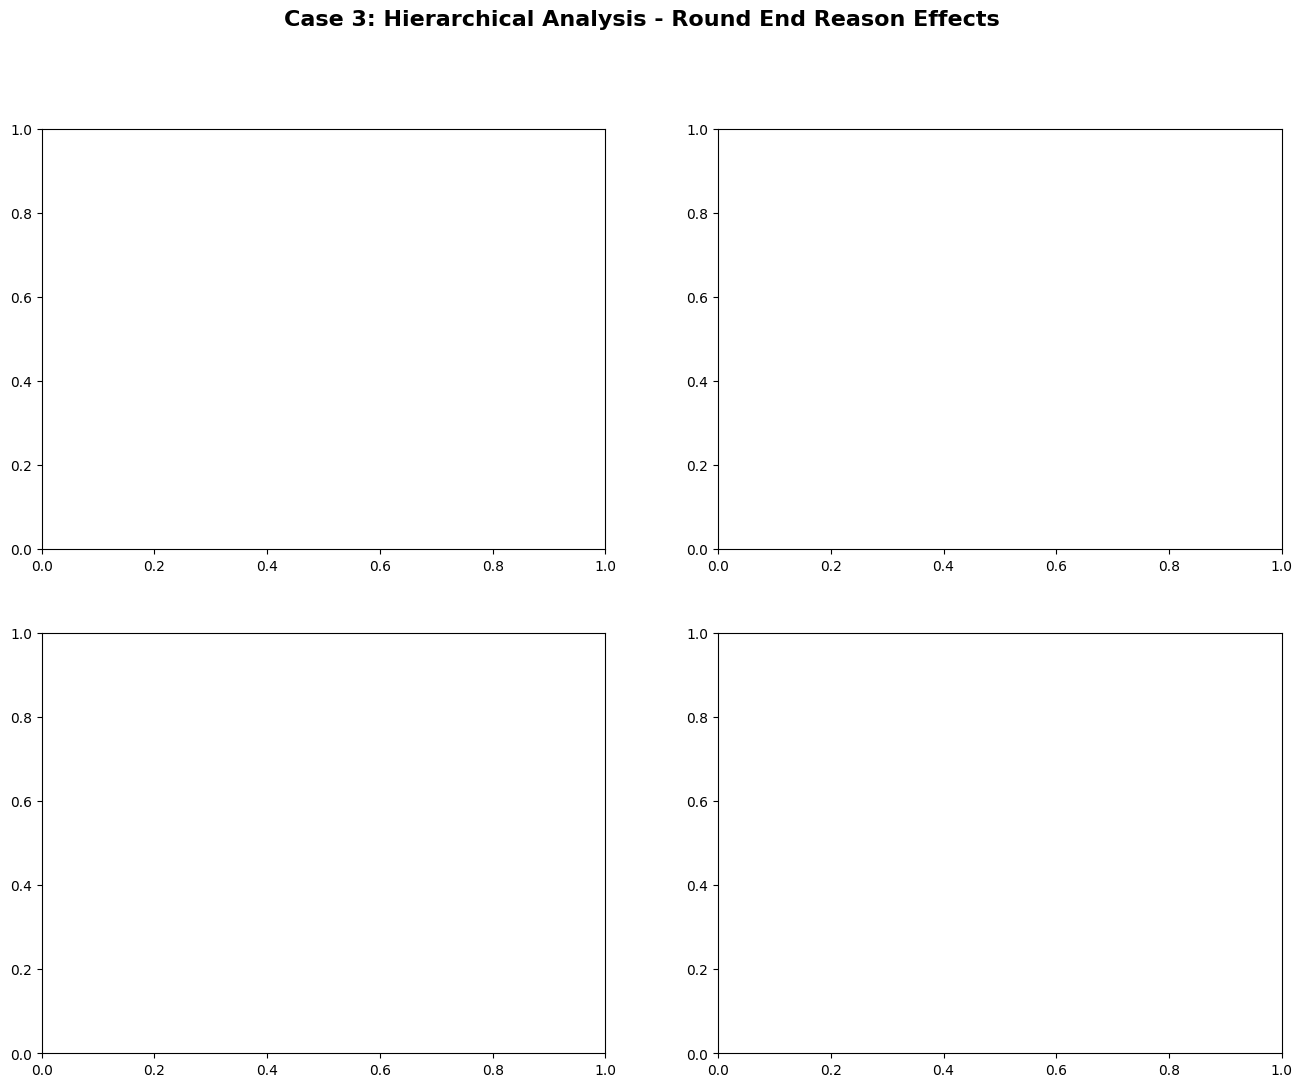

In [38]:
# Visualizations for Case 3
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Case 3: Hierarchical Analysis - Round End Reason Effects', fontsize=16, fontweight='bold')

# Plot 1: CT vs T Survivors by Round End Reason
ax1 = axes[0, 0]
ct_surv_means = []
t_surv_means = []
for reason in top_round_ends:
    ct_mean = level2_df[(level2_df['round_end_reason'] == reason) & 
                        (level2_df['side'] == 'CT')]['survivors_mean'].mean()
    t_mean = level2_df[(level2_df['round_end_reason'] == reason) & 
                       (level2_df['side'] == 'T')]['survivors_mean'].mean()
    
    reason_data = detailed_df[detailed_df['round_end_reason'] == reason]
    ct_surv_means.append(reason_data['ct_survivors'].mean())
    t_surv_means.append(reason_data['t_survivors'].mean())

x = np.arange(len(top_round_ends))
width = 0.35
bars1 = ax1.bar(x - width/2, ct_surv_means, width, label='CT', alpha=0.7, color='blue')
bars2 = ax1.bar(x + width/2, t_surv_means, width, label='T', alpha=0.7, color='orange')
ax1.set_xlabel('Round End Reason')
ax1.set_ylabel('Mean Survivors')
ax1.set_title('Average Survivors by Round End Reason', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([str(r)[:15] for r in top_round_ends], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Saved Equipment by Round End Reason (as % of original)
ax2 = axes[0, 1]
x = np.arange(len(level3_df))
width = 0.35
bars1 = ax2.bar(x - width/2, level3_df['ct_saved_equipment'], width, 
               label='CT', alpha=0.7, color='blue')
bars2 = ax2.bar(x + width/2, level3_df['t_saved_equipment'], width, 
               label='T', alpha=0.7, color='orange')
ax2.set_xlabel('Round End Reason')
ax2.set_ylabel('Mean Saved Equipment (% of Original)')
ax2.set_title('Saved Equipment by Round End Reason (% of Original)', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([str(r)[:15] for r in level3_df['round_end_reason']], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Money Earned by Round End Reason
ax3 = axes[1, 0]
x = np.arange(len(level4_df))
width = 0.35
bars1 = ax3.bar(x - width/2, level4_df['ct_player_money'], width, 
               label='CT', alpha=0.7, color='blue')
bars2 = ax3.bar(x + width/2, level4_df['t_player_money'], width, 
               label='T', alpha=0.7, color='orange')
ax3.set_xlabel('Round End Reason')
ax3.set_ylabel('Mean Money Earned ($)')
ax3.set_title('Money Earned by Round End Reason', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels([str(r)[:15] for r in level4_df['round_end_reason']], rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Round End Reason Distribution by CSF Winner
ax4 = axes[1, 1]
# Get CSF Favors Higher Eq, CT Wins data
csf_high_ct = level1_df[(level1_df['csf_prediction'] == 'CSF Favors Higher Eq') & 
                        (level1_df['winner'] == 'CT')].groupby('round_end_reason')['percentage'].sum()
# Get CSF Favors Higher Eq, T Wins data  
csf_high_t = level1_df[(level1_df['csf_prediction'] == 'CSF Favors Higher Eq') & 
                       (level1_df['winner'] == 'T')].groupby('round_end_reason')['percentage'].sum()

if len(csf_high_ct) > 0 and len(csf_high_t) > 0:
    reasons = list(set(csf_high_ct.index) | set(csf_high_t.index))[:5]
    ct_pcts = [csf_high_ct.get(r, 0) for r in reasons]
    t_pcts = [csf_high_t.get(r, 0) for r in reasons]
    
    x = np.arange(len(reasons))
    width = 0.35
    bars1 = ax4.bar(x - width/2, ct_pcts, width, label='CT Wins', alpha=0.7, color='blue')
    bars2 = ax4.bar(x + width/2, t_pcts, width, label='T Wins', alpha=0.7, color='orange')
    ax4.set_xlabel('Round End Reason')
    ax4.set_ylabel('Percentage (%)')
    ax4.set_title('Round End When CSF Favors Higher Eq', fontsize=13, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels([str(r)[:15] for r in reasons], rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()